In [1]:
import pandas as pd
import numpy as np
from lsynth import compute_upsilon, generate_syndata
import seaborn as sns

#model_path='./modelHRS72p05_train.gz'
#DATA="./HRSvar72_test.csv"
DATA='../datasets/gss_2018.csv'
model_path="../datasets/gss_2018.joblib"
orig_df=pd.read_csv(DATA,keep_default_na=False)

# Generate synthetic data 

In [2]:
# 1. Generate synthetic data with a chosen generator
df_lsm = generate_syndata(
    num=1000,
    model_path=model_path,
    gen_algorithm="LSM",
    n_workers=11,
)

Loading model from ../datasets/gss_2018.joblib ...
Generating 1000 rows via LSM (qsample).


qsample(LSM, threads=11): 100%|█████████████| 1000/1000 [09:49<00:00,  1.70it/s]


In [3]:
# 1. Generate synthetic data with a chosen generator
df_baseline = generate_syndata(
    num=1000,
    gen_algorithm="BASELINE",
    orig_df=orig_df,
    n_workers=11,
)

Generating 1000 rows via BASELINE (independent columns).


In [4]:
# 1. Generate synthetic data with a chosen generator
df_ctgan = generate_syndata(
    num=1000,
    gen_algorithm="CTGAN",
    orig_df=orig_df.sample(50),
    n_workers=11,
)

Generating 1000 rows via CTGAN.


# Compute Upsilon on synthetic dataframes

Loading model from ../datasets/gss_2018.joblib ...
Computing Upsilon on DataFrame with 1000 rows ...


average_fidelity(threads=11): 100%|█████████| 1000/1000 [04:20<00:00,  3.83it/s]

0.7965520279802961


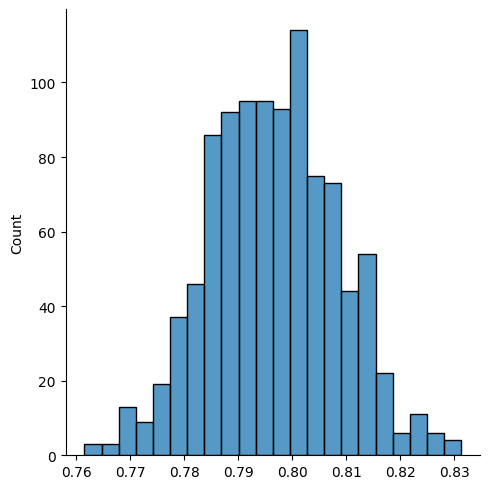

In [5]:
ups_lsm, _ = compute_upsilon(
    df_lsm,
    model_path=model_path,
    n_workers=11,
)
print(np.nanmean(ups_lsm))
sns.displot(ups_lsm)

In [6]:
df_baseline.columns=orig_df.columns

Loading model from ../datasets/gss_2018.joblib ...
Computing Upsilon on DataFrame with 1000 rows ...


average_fidelity(threads=11): 100%|█████████| 1000/1000 [04:38<00:00,  3.59it/s]


0.747578746391351


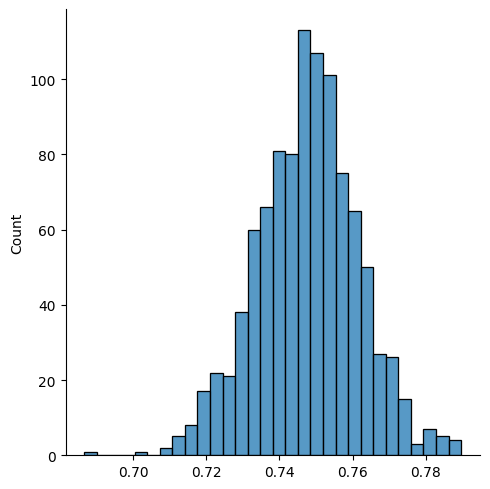

In [7]:
ups_baseline, _ = compute_upsilon(
    df_baseline,#.round(0).astype(int),
    model_path=model_path,
    n_workers=11,
)
print(np.nanmean(ups_baseline))
sns.displot(ups_baseline)

Loading model from ../datasets/gss_2018.joblib ...
Computing Upsilon on DataFrame with 1000 rows ...


average_fidelity(threads=11): 100%|█████████| 1000/1000 [04:55<00:00,  3.39it/s]


0.7399723144300128


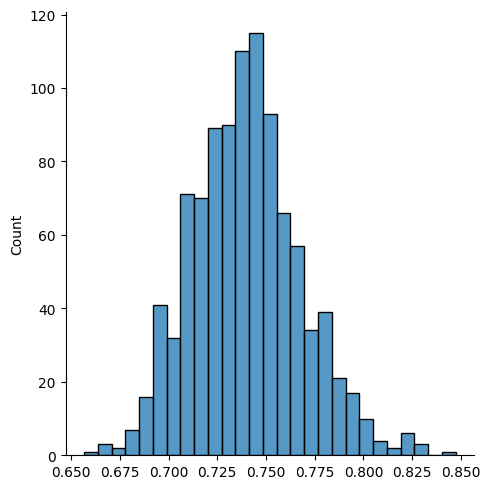

In [8]:
ups_ctgan, _ = compute_upsilon(
    df_ctgan,
    model_path=model_path,
    n_workers=11,
)
print(np.nanmean(ups_ctgan))
sns.displot(ups_ctgan)

In [ ]:
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
# Pick a CRAN mirror (required in non-interactive sessions)
ro.r('options(repos = c(CRAN="https://cloud.r-project.org"))')

# Install synthpop if missing
ro.r('if (!requireNamespace("synthpop", quietly=TRUE)) install.packages("synthpop")')


# Load synthpop
ro.r('library(synthpop)')






# Example dataframe
df = orig_df.copy()#pd.read_csv("data.csv")

# Convert pandas -> R, run synthpop, convert back R -> pandas
with localconverter(ro.default_converter + pandas2ri.converter):
    r_df = ro.conversion.py2rpy(df)
    ro.globalenv["df"] = r_df

    #ro.r("syn_obj <- syn(df, seed=123, maxfaclevels=2000)")


    ro.r("""
    library(synthpop)
    options(repos=c(CRAN="https://cloud.r-project.org"))
    
    # 1) initial run just to get defaults
    tmp <- syn(df, seed=123, maxfaclevels=300, method='cart')
    
    pm <- tmp$predictor.matrix
    
    high <- c('SPIND10','COOCC10', 'COIND10','MAIND10','MAJOR1','majorcol','ISCO08','PAISCO08','MAISCO08','SPISCO08','COISCO08')
    high <- intersect(high, colnames(df))
    
    # Don't use high-cardinality vars as predictors for others
    pm[, high] <- 0
    
    # 2) rerun with modified predictor matrix
    syn_obj <- syn(df, seed=123, maxfaclevels=300, predictor.matrix=pm, method='cart')
    """)


    
    pop_df = ro.conversion.rpy2py(ro.r("syn_obj$syn"))



CAUTION: Your data set has fewer observations (1784) than we advise.
We suggest that there should be at least 10440 observations
(100 + 10 * no. of variables used in modelling the data).
Please check your synthetic data carefully with functions
compare(), utility.tab(), and utility.gen().


Variable(s): wrkstat, HRS1, HRS2, evwork, wrkslf, wrkgovt, OCC10, PRESTG10, PRESTG105PLUS, INDUS10, marital, martype, divorce, widowed, spwrksta, SPHRS1, SPHRS2, spevwork, cowrksta, cowrkslf, coevwork, COHRS1, COHRS2, spwrkslf, SPOCC10, SPPRES10, SPPRES105PLUS, SPIND10, COOCC10, COIND10, pawrkslf, PAOCC10, PAPRES10, PAPRES105PLUS, PAIND10, mawrkslf, MAOCC10, MAPRES10, MAPRES105PLUS, MAIND10, sibs, childs, age, agekdbrn, educ, paeduc, maeduc, speduc, coeduc, codeg, degree, padeg, madeg, spdeg, MAJOR1, MAJOR2, dipged, sex, race, RES16, REG16, MOBILE16, FAMILY16, FAMDIF16, mawrkgrw, INCOM16, born, parborn, granborn, babies, preteen, teens, unrelat, earnrs, income, rincome, INCOME16, RINCOM16, region, x

In [ ]:
ups_perm, _ = compute_upsilon(
    orig_df.sample(1000),
    model_path=model_path,
    n_workers=11,
)
print(np.nanmean(ups_perm))
sns.displot(ups_perm)

In [ ]:
ups_pop, _ = compute_upsilon(
    pop_df.sample(1000),
    model_path=model_path,
    n_workers=11,
)
print(np.nanmean(ups_pop))
sns.displot(ups_pop)

In [ ]:
import pylab as plt
sns.distplot(ups_baseline,label='baseline')
sns.distplot(ups_ctgan,label='ctgan')
sns.distplot(ups_lsm,label='lsm')
#sns.distplot(ups_pop,label='pop')
plt.legend()


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


def real_vs_synth_auc(
    orig_df: pd.DataFrame,
    syn_df: pd.DataFrame,
    *,
    test_size: float = 0.25,
    random_state: int = 123,
    cv_folds: int | None = None,
    max_rows: int | None = None,
) -> dict:
    """
    Train a classifier to separate real vs synthetic (categorical tabular data),
    and report AUC. Uses one-hot + logistic regression.

    If cv_folds is provided, returns cross-validated AUC on the full dataset.
    Otherwise returns a single train/test split AUC.

    max_rows optionally subsamples each dataset to speed things up.
    """
    # Basic checks
    if list(orig_df.columns) != list(syn_df.columns):
        raise ValueError("orig_df and syn_df must have identical columns in the same order.")

    # Optional subsampling (balanced)
    if max_rows is not None:
        n0 = min(len(orig_df), max_rows)
        n1 = min(len(syn_df), max_rows)
        orig_df = orig_df.sample(n=n0, random_state=random_state)
        syn_df = syn_df.sample(n=n1, random_state=random_state)

    # Ensure everything is treated as categorical tokens
    X_real = orig_df.copy()
    X_synth = syn_df.copy()
    for c in X_real.columns:
        X_real[c] = X_real[c].astype("string")
        X_synth[c] = X_synth[c].astype("string")

    X = pd.concat([X_real, X_synth], axis=0, ignore_index=True)
    y = np.concatenate([np.zeros(len(X_real), dtype=int), np.ones(len(X_synth), dtype=int)])

    # Model: one-hot categorical -> logistic regression
    pipe = Pipeline(
        steps=[
            ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
            ("clf", LogisticRegression(max_iter=2000, n_jobs=-1)),
        ]
    )

    if cv_folds is not None and cv_folds >= 2:
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
        aucs = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
        return {
            "mode": "cv",
            "cv_folds": cv_folds,
            "auc_mean": float(aucs.mean()),
            "auc_std": float(aucs.std(ddof=1)) if len(aucs) > 1 else 0.0,
            "aucs": aucs,
            "n_real": len(X_real),
            "n_synth": len(X_synth),
        }

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    pipe.fit(X_train, y_train)
    p = pipe.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, p)

    return {
        "mode": "holdout",
        "test_size": test_size,
        "auc": float(auc),
        "n_real": len(X_real),
        "n_synth": len(X_synth),
    }


# Example:
# res = real_vs_synth_auc(orig_df, syn_df, cv_folds=5, max_rows=20000)
# print(res)


In [ ]:
real_vs_synth_auc(orig_df, pop_df.astype(int), cv_folds=5, max_rows=20000)

In [ ]:
real_vs_synth_auc(orig_df.sample(10), df_lsm.sample(20), cv_folds=5, max_rows=20000)

In [ ]:
sns.distplot(pop_df.iloc[:,30])
sns.distplot(orig_df.iloc[:,30])
sns.distplot(df_ctgan.iloc[:,30])
sns.distplot(df_lsm.iloc[:,30].replace('',np.nan))


# How Novel Is The Generated Data

One-hot cosine similarity between categorical rows; off-diagonal block quantifies synthetic novelty versus near-copying.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

def row_similarity_blockplot(orig_df: pd.DataFrame,
                             syn_df: pd.DataFrame,
                             *,
                             metric: str = "cosine",
                             max_rows: int | None = 2000,
                             random_state: int = 123,
                             missing_token: str = "__MISSING__",
                             show_block_means: bool = True):
    if list(orig_df.columns) != list(syn_df.columns):
        raise ValueError("orig_df and syn_df must have identical columns in the same order.")

    o = orig_df.copy()
    s = syn_df.copy()
    if max_rows is not None:
        n = min(len(o), len(s), max_rows)
        o = o.sample(n=n, random_state=random_state).reset_index(drop=True)
        s = s.sample(n=n, random_state=random_state).reset_index(drop=True)

    def normalize(df: pd.DataFrame) -> pd.DataFrame:
        df = df.replace("", pd.NA)
        df = df.astype("string").fillna(missing_token)
        return df.astype(object)

    o = normalize(o)
    s = normalize(s)

    if metric == "match":
        X = np.vstack([o.to_numpy(), s.to_numpy()])
        G = (X[:, None, :] == X[None, :, :]).mean(axis=2).astype(np.float32)

    elif metric == "cosine":
        comb = pd.concat([o, s], axis=0, ignore_index=True)
        enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=np.float32)
        X = enc.fit_transform(comb)

        norms = np.linalg.norm(X, axis=1)
        norms[norms == 0] = 1.0
        G = (X @ X.T) / (norms[:, None] * norms[None, :])

    else:
        raise ValueError("metric must be 'cosine' or 'match'.")

    n = len(o)

    # Block means (RR, RS, SR, SS)
    rr = float(G[:n, :n].mean())
    rs = float(G[:n, n:].mean())
    sr = float(G[n:, :n].mean())
    ss = float(G[n:, n:].mean())
    block_means = np.array([[rr, rs],
                            [sr, ss]], dtype=float)

    # Plot full similarity + (optional) 2x2 block mean heatmap
    if show_block_means:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        im0 = axes[0].imshow(G, aspect="auto")
        axes[0].axhline(n - 0.5)
        axes[0].axvline(n - 0.5)
        axes[0].set_title(f"Row–row similarity ({metric})")
        fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

        BM = block_means#-block_means[0,1]
        print(BM)
        im1 = axes[1].imshow(BM, aspect="equal",vmin=.35,vmax=BM[0][0],cmap='Spectral_r')
        axes[1].set_xticks([0, 1], labels=["Real", "Synth"])
        axes[1].set_yticks([0, 1], labels=["Real", "Synth"])
        axes[1].set_title("2×2 block mean similarity")
        for (i, j), v in np.ndenumerate(BM):
            axes[1].text(j, i, f"{v:.3f}", ha="center", va="center")
        fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(7, 6))
        im = plt.imshow(G, aspect="auto")
        plt.axhline(n - 0.5)
        plt.axvline(n - 0.5)
        plt.title(f"Row–row similarity ({metric})")
        plt.colorbar(im, label="similarity")
        plt.tight_layout()
        plt.show()

    off_block = G[:n, n:]  # real x synth
    nn = off_block.max(axis=0)

    return {
        "n_rows_each": n,
        "nearest_real_similarity_mean": float(nn.mean()),
        "nearest_real_similarity_median": float(np.median(nn)),
        "nearest_real_similarity_p95": float(np.quantile(nn, 0.95)),
        "missing_token_used": missing_token,
        "block_means": {
            "real_real": rr,
            "real_synth": rs,
            "synth_real": sr,
            "synth_synth": ss,
        },
    }

## LSM synthetic data

In [ ]:
statslsm = row_similarity_blockplot(orig_df, df_lsm, metric="cosine", max_rows=2000)
print(statslsm)

## POP synthetic data

In [ ]:
statspop = row_similarity_blockplot(orig_df, pop_df.astype(int), metric="cosine", max_rows=2000)
print(statspop)

# CTGAN synthetic data

In [ ]:
statsctgan = row_similarity_blockplot(orig_df, df_ctgan, metric="cosine", max_rows=2000)
print(statsctgan)

# Baseline synthetic data

In [ ]:
statsbaseline = row_similarity_blockplot(orig_df.head(100), df_baseline, metric="cosine", max_rows=2000)
print(statsbaseline)

# Permutated Original Data as "synthetic"

In [ ]:
statsperm = row_similarity_blockplot(orig_df.head(100), orig_df.sample(100), metric="cosine", max_rows=2000)
print(statsperm)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_generator_map(results, *, ups_key="upsilon_median", sim_key="nearest_real_similarity_median",
                       annotate=True, title="Generator map: Upsilon vs nearest-real similarity"):
    """
    results: dict like
      {
        "LSM": {"upsilon_median": 0.78, "nearest_real_similarity_median": 0.44},
        "synthpop": {"upsilon_median": 0.81, "nearest_real_similarity_median": 0.73},
        ...
      }

    x = nearest-real similarity (higher => closer to real rows; less movement)
    y = Upsilon (higher => better structural fidelity)
    """
    names = list(results.keys())
    x = np.array([results[n][sim_key] for n in names], dtype=float)
    y = np.array([results[n][ups_key] for n in names], dtype=float)

    plt.figure(figsize=(7, 5))
    plt.scatter(x, y)
    plt.xlabel(sim_key.replace("_", " "))
    plt.ylabel(ups_key.replace("_", " "))
    plt.title(title)

    if annotate:
        for n, xi, yi in zip(names, x, y):
            plt.annotate(n, (xi, yi), textcoords="offset points", xytext=(6, 4), ha="left")

    plt.tight_layout()
    plt.show()


# Example usage (fill in your Upsilon medians/means)
results = {
    "LSM":     {"upsilon_median": np.median(ups_lsm), "nearest_real_similarity_median": 1/statslsm['nearest_real_similarity_median']},
    "synthpop":{"upsilon_median": np.median(ups_pop), "nearest_real_similarity_median": 1/statspop['nearest_real_similarity_median']},
    "baseline":     {"upsilon_median": np.median(ups_baseline), "nearest_real_similarity_median": 1/statsbaseline['nearest_real_similarity_median']},
    "CTGAN":{"upsilon_median": np.median(ups_ctgan), "nearest_real_similarity_median": 1/statsctgan['nearest_real_similarity_median']},
    "permutation":{"upsilon_median": np.median(ups_perm), "nearest_real_similarity_median": 1/statsperm['nearest_real_similarity_median']},
}

plot_generator_map(results, ups_key="upsilon_median", sim_key="nearest_real_similarity_median")
